In [2]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

%matplotlib inline
plt.rcParams['image.cmap'] = 'Paired'
#sns.set(font_scale=2)

In [3]:
# Parent directory for the results of this run
group_results_directory = '/data/jpetrie/MEOPAR/SalishSea/results/remin_param_sweep_new_depth/'
tracer_file = 'SS5x5_1h_20150201_20150501_ptrc_T.nc'
individual_directories = []
param_vals = []
for file in os.listdir(group_results_directory):
    if file.startswith("nampisrem_zz_remin_D_DON_"):
        if os.path.isfile(group_results_directory + file + '/' + tracer_file):
            val = float(file.split("nampisrem_zz_remin_D_DON_")[1])
            individual_directories.append(file)
            param_vals.append(val)
        else:
            print(group_results_directory + file + tracer_file)

tracer_datasets = [xr.open_dataset(group_results_directory + '/' + file +'/' + tracer_file) for file in individual_directories]
dataset_dict = dict(zip(param_vals, tracer_datasets))

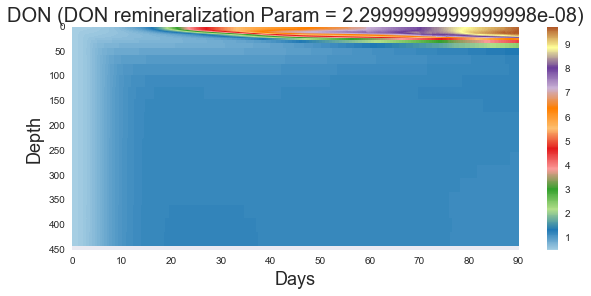

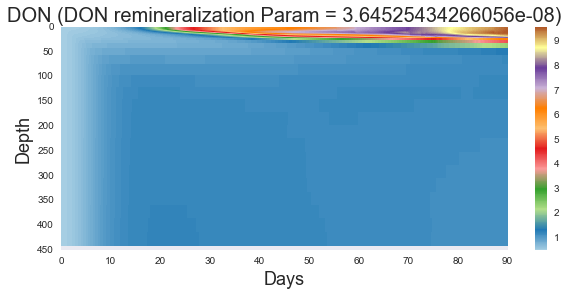

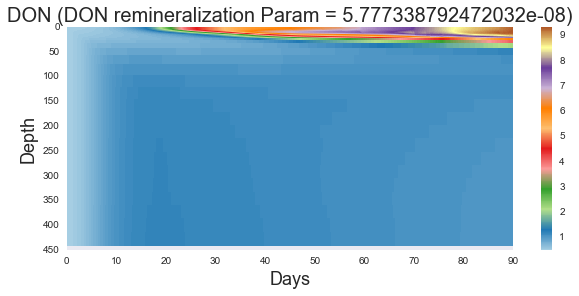

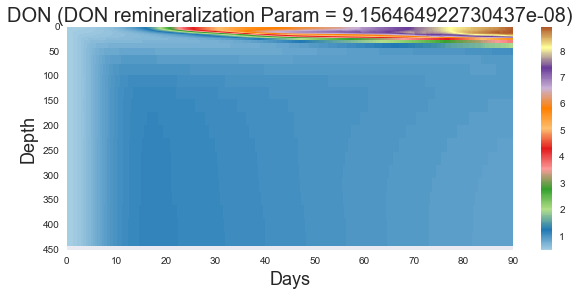

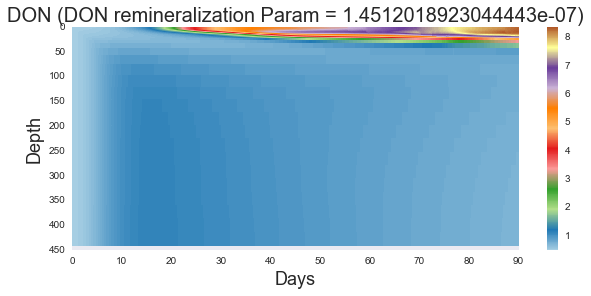

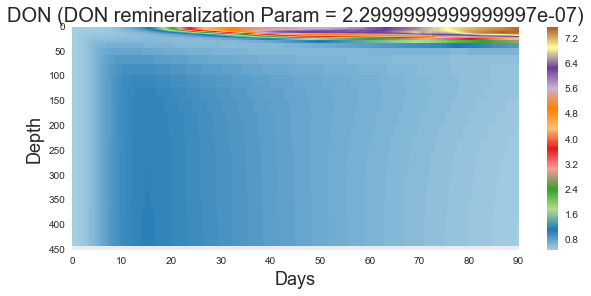

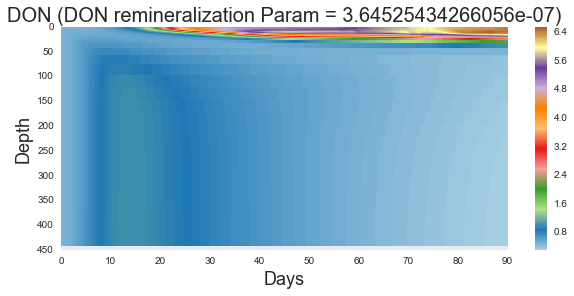

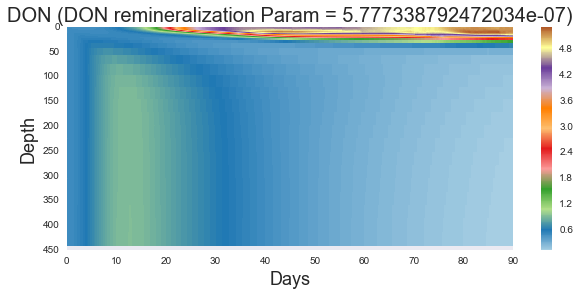

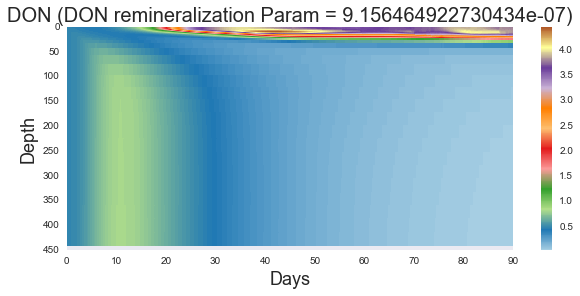

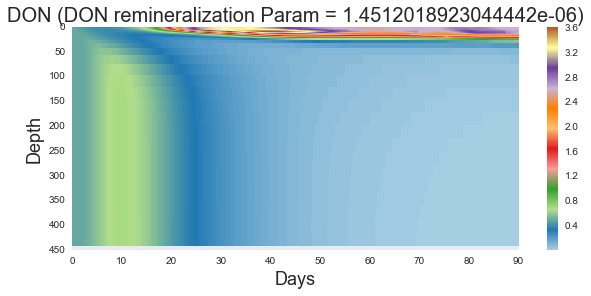

In [4]:
# Plot depth/time/DON heatmap for each value of alpha
keys = (list(dataset_dict.keys()))
keys.sort()

for DON_remin_const in keys:
    z = dataset_dict[DON_remin_const].deptht.values
    t= np.array([float(x) for x in dataset_dict[DON_remin_const].time_centered.values])
    tz,zt=np.meshgrid((t[:] - t[0])/10**9/3600/24,z[:])
    
    fig, ax = plt.subplots(1, 1,figsize=(10,4))
    mesh=plt.pcolormesh(tz,zt,dataset_dict[DON_remin_const].DOC.values[:,:,2,2].T)
    fig.colorbar(mesh)
    plt.gca().invert_yaxis()
    plt.title("DON (DON remineralization Param = " + str(DON_remin_const)+")", size = 20)
    plt.xlabel("Days", size =18)
    plt.ylabel("Depth", size = 18)

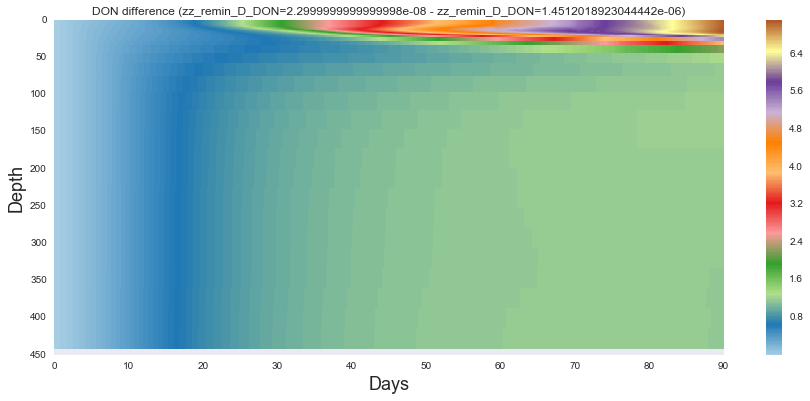

In [5]:
# Plot the difference in DON concentration vs depth and time
fig, ax = plt.subplots(1, 1,figsize=(15,6))
param_1 = min(param_vals)
param_2 = max(param_vals)
mesh=plt.pcolormesh(tz,zt,dataset_dict[param_1].DOC.values[:,:,2,2].T - dataset_dict[param_2].DOC.values[:,:,2,2].T)
fig.colorbar(mesh)
plt.gca().invert_yaxis()
plt.xlabel("Days", size =18)
plt.ylabel("Depth", size = 18)
plt.title("DON difference (zz_remin_D_DON=" + str(param_1) + " - zz_remin_D_DON=" +str(param_2)+ ")")

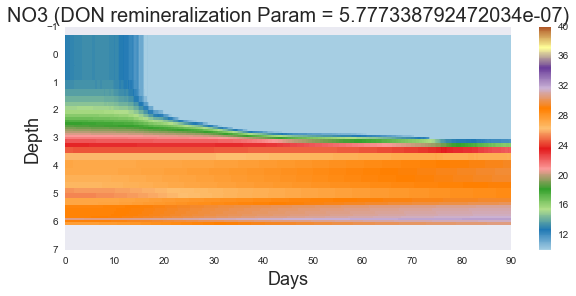

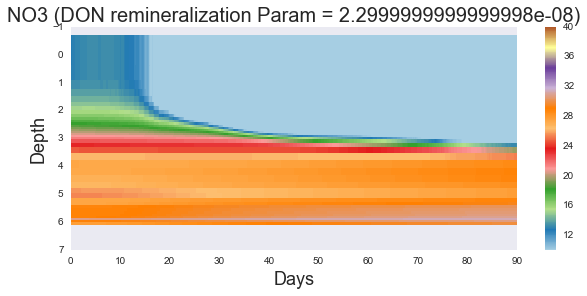

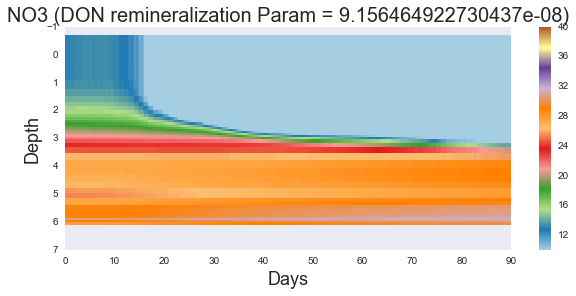

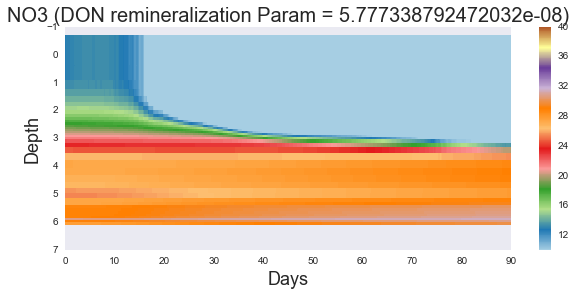

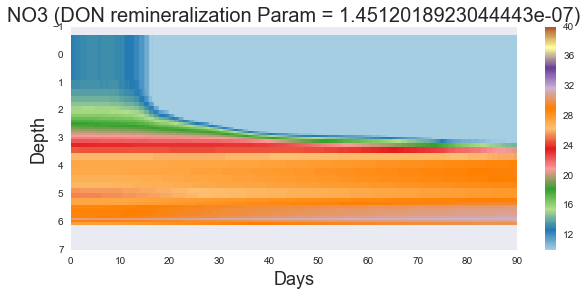

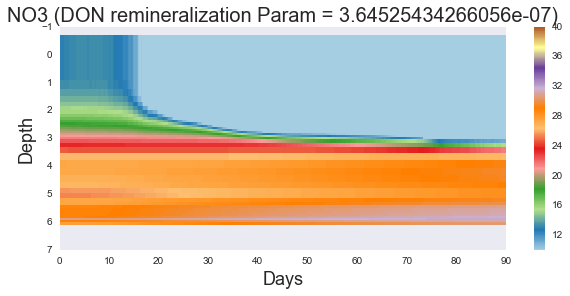

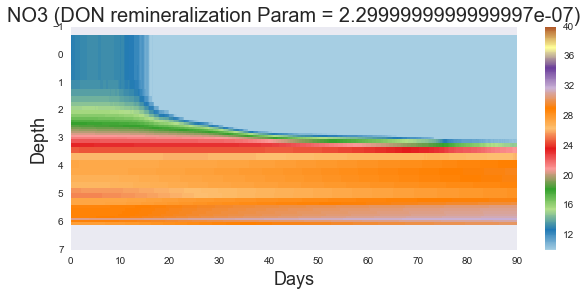

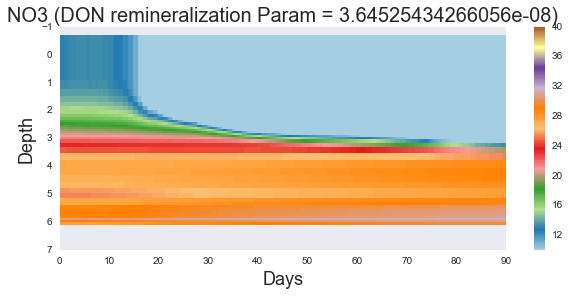

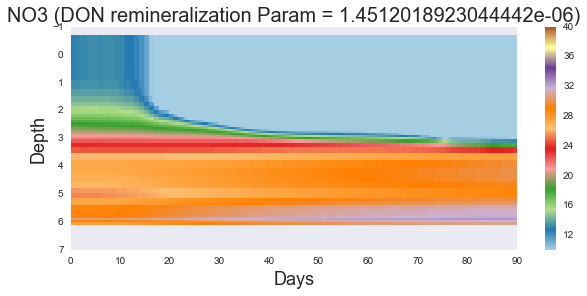

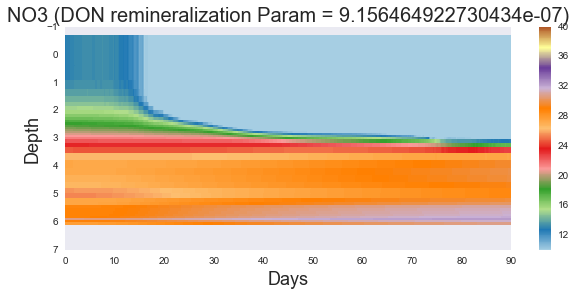

In [6]:
# Plot depth/time/NO3 heatmap for each value
for DON_remin_const in dataset_dict:
    z = dataset_dict[DON_remin_const].deptht.values
    t= np.array([float(x) for x in dataset_dict[DON_remin_const].time_centered.values])
    tz,zt=np.meshgrid((t[:] - t[0])/10**9/3600/24,z[:])
    
    fig, ax = plt.subplots(1, 1,figsize=(10,4))
    mesh=plt.pcolormesh(tz,np.log(zt),dataset_dict[DON_remin_const].NO3.values[:,:,2,2].T, vmin = 10, vmax = 40)
    fig.colorbar(mesh)
    plt.gca().invert_yaxis()
    plt.title("NO3 (DON remineralization Param = " + str(DON_remin_const)+")", size = 20)
    plt.xlabel("Days", size =18)
    plt.ylabel("Depth", size = 18)

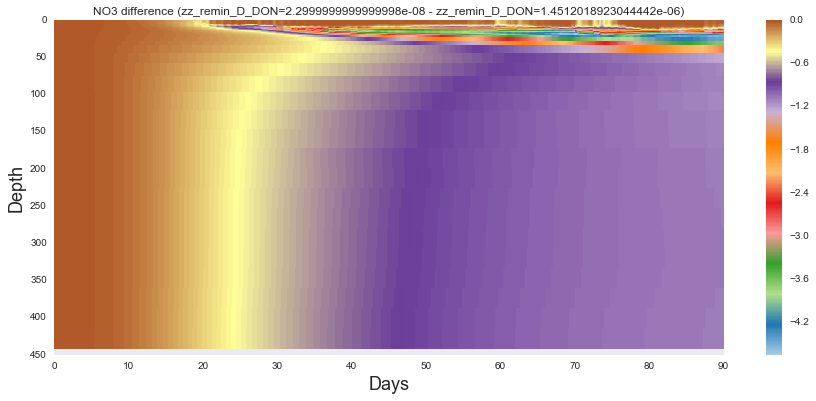

In [7]:
# Plot the difference in NO3 concentration vs depth and time
fig, ax = plt.subplots(1, 1,figsize=(15,6))
param_1 = min(param_vals)
param_2 = max(param_vals)

mesh=plt.pcolormesh(tz,zt,dataset_dict[param_1].NO3.values[:,:,2,2].T - dataset_dict[param_2].NO3.values[:,:,2,2].T)
fig.colorbar(mesh)
plt.gca().invert_yaxis()
plt.xlabel("Days", size =18)
plt.ylabel("Depth", size = 18)
plt.title("NO3 difference (zz_remin_D_DON=" + str(param_1) + " - zz_remin_D_DON=" +str(param_2)+ ")")

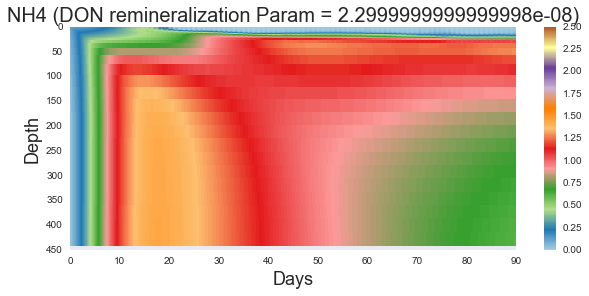

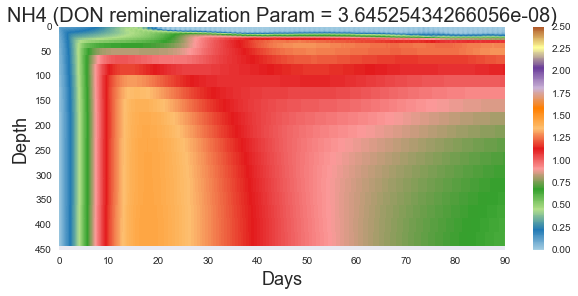

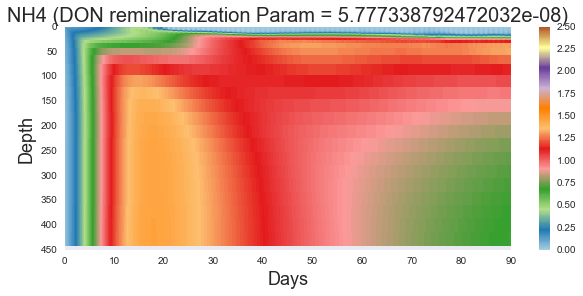

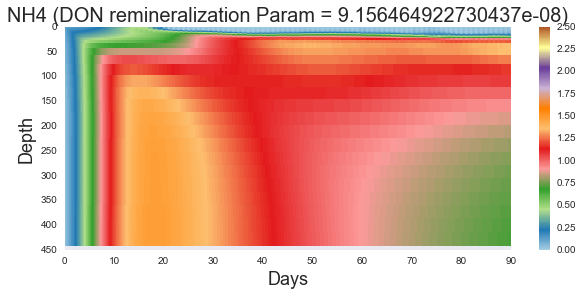

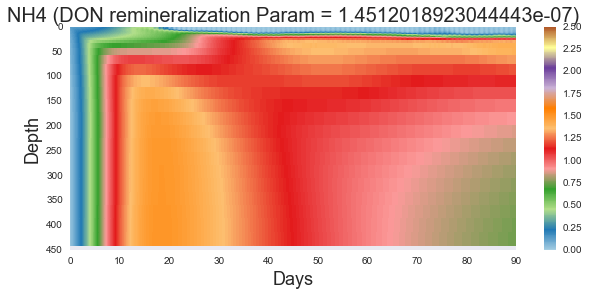

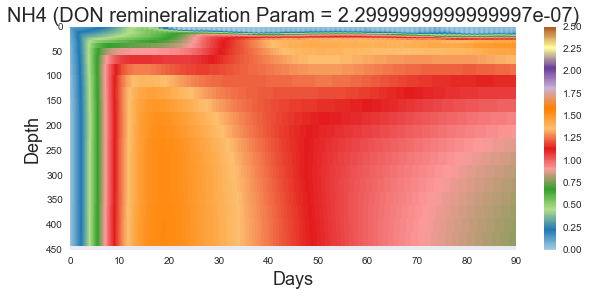

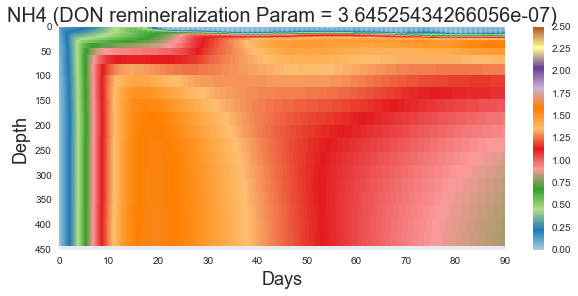

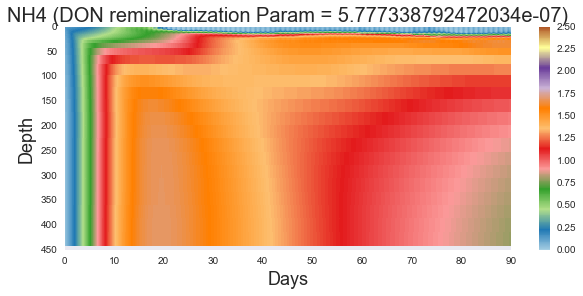

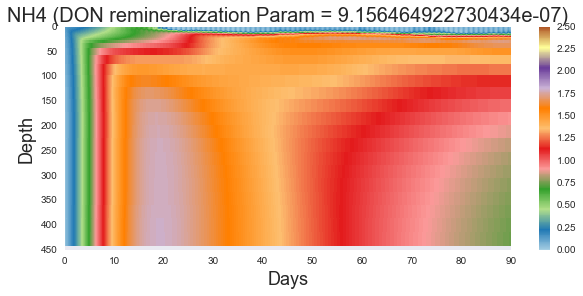

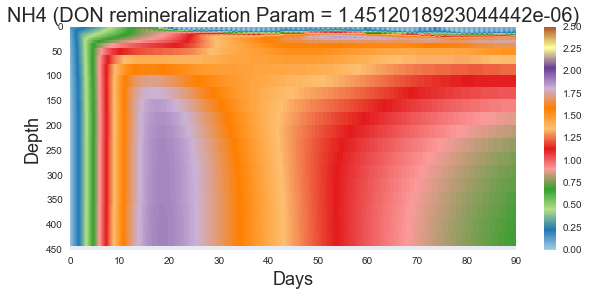

In [8]:
# Plot depth/time/NH4 heatmap for each value
for DON_remin_const in sorted(list(dataset_dict.keys())):
    z = dataset_dict[DON_remin_const].deptht.values
    t= np.array([float(x) for x in dataset_dict[DON_remin_const].time_centered.values])
    tz,zt=np.meshgrid((t[:] - t[0])/10**9/3600/24,z[:])
    
    fig, ax = plt.subplots(1, 1,figsize=(10,4))
    mesh=plt.pcolormesh(tz,zt,dataset_dict[DON_remin_const].NH4.values[:,:,2,2].T, vmin = 0, vmax = 2.5)
    fig.colorbar(mesh)
    plt.gca().invert_yaxis()
    plt.title("NH4 (DON remineralization Param = " + str(DON_remin_const)+")", size = 20)
    plt.xlabel("Days", size =18)
    plt.ylabel("Depth", size = 18)

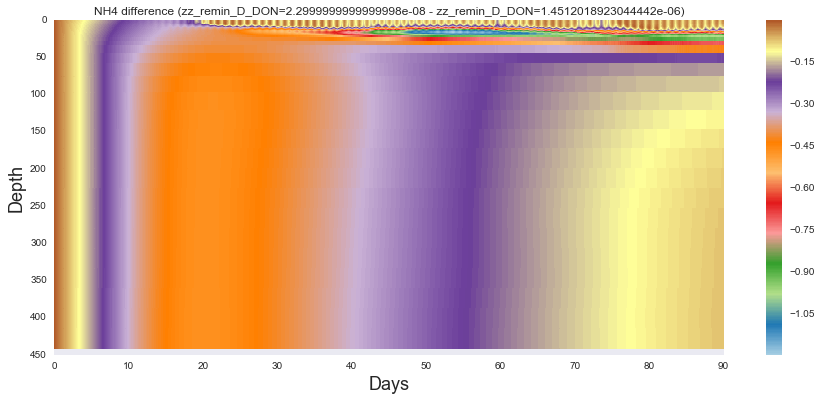

In [9]:
# Plot the difference in NH4 concentration vs depth and time
fig, ax = plt.subplots(1, 1,figsize=(15,6))
param_1 = min(param_vals)
param_2 = max(param_vals)

mesh=plt.pcolormesh(tz,zt,dataset_dict[param_1].NH4.values[:,:,2,2].T - dataset_dict[param_2].NH4.values[:,:,2,2].T)
fig.colorbar(mesh)
plt.gca().invert_yaxis()
plt.xlabel("Days", size =18)
plt.ylabel("Depth", size = 18)
plt.title("NH4 difference (zz_remin_D_DON=" + str(param_1) + " - zz_remin_D_DON=" +str(param_2)+ ")")

In [10]:
# Convert list of xarrays to a single pandas dataframe. Easier to manipulate and plot
dataframe_list = []
for DON_remin_const in dataset_dict:
    df = dataset_dict[DON_remin_const].to_dataframe().query('x == 2 and y == 2 and axis_nbounds == 0')
    df['DON_CONST'] = DON_remin_const
    dataframe_list.append(df)

df_subset = pd.concat(dataframe_list)

df_subset.reset_index(inplace=True) # Get rid of that multiindex madness

In [11]:
# Create a dataframe with depth averaged tracer values. If all grid heights are the same this is the mean value
mesh_mask = xr.open_dataset(group_results_directory + '/' + individual_directories[0] +'/' + 'mesh_mask.nc')

grid_heights = pd.DataFrame({'deptht': mesh_mask['gdept_1d'].values[0], 'GRID_HEIGHT' : mesh_mask['e3t_1d'].values[0]})


grid_heights = grid_heights.round({'deptht':3})
df_subset = df_subset.round({'deptht':3})

depth_averaged = df_subset.groupby(['time_counter','DON_CONST','x','y']).mean()
depth_averaged.reset_index(inplace=True)
df_subset = pd.merge(df_subset, grid_heights, on='deptht', how = "left")



In [12]:
grouped = df_subset.groupby(['time_counter','DON_CONST','x','y'])

def weighted(x, cols, w="deptht"):
             return pd.Series(np.average(x[cols], weights=x[w], axis=0), cols)

depth_summed = grouped.apply(weighted, plot_vars)



In [13]:
depth_averaged = df_subset.groupby(['time_counter','DON_CONST','x','y']).mean()
depth_averaged.reset_index(inplace=True)

In [14]:
(depth_summed).reset_index(inplace=True)

[   0.5      5.5     10.505   15.634   24.1     76.586  199.573  333.75 ]


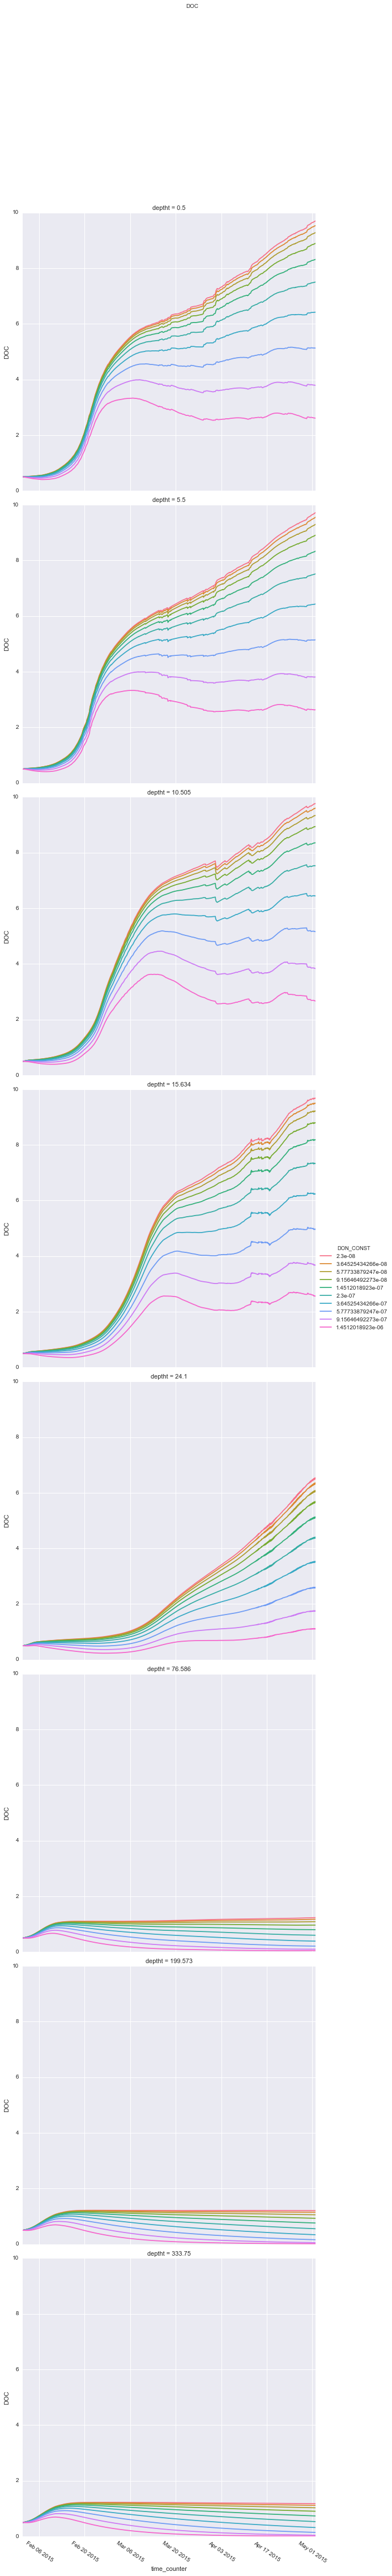

In [19]:
plot_vars = ['DOC']#[ 'DOC','MICZ', 'MYRI', 'NH4', 'NO3', 'O2', 'PHY', 'PHY2', 'POC', 'Si', 'bSi']



depth_vals = (df_subset['deptht'].unique())[0:40:5]

print(depth_vals)
for var in plot_vars:
    fg = sns.FacetGrid(data=df_subset.query("deptht in @depth_vals"), hue='DON_CONST',row = "deptht",size =8)
    fg.map(plt.plot, 'time_counter', var).add_legend()
    fg.set_xticklabels(rotation=-35)
    plt.subplots_adjust(top=0.9)
    fg.fig.suptitle(var)

In [121]:
sum_vars = ['z']

test_df = pd.DataFrame({'x':[1,1,1,1,1,2,2,2,2,2], 'y': [1,2,3,1,2,3,1,2,3,1], 'z':[1,2,3,4,5,6,7,8,9,10], 'deptht':[1,2,3,4,5,6,7,8,9,10] })
print(test_df)
grouped = test_df.groupby(['x','y'])
print(grouped)
def weighted(x, cols, w="deptht"):
             return pd.Series(np.average(x[cols], weights=x[w], axis=0), cols)

a = grouped.apply(weighted, sum_vars)
print(a)

   deptht  x  y   z
0       1  1  1   1
1       2  1  2   2
2       3  1  3   3
3       4  1  1   4
4       5  1  2   5
5       6  2  3   6
6       7  2  1   7
7       8  2  2   8
8       9  2  3   9
9      10  2  1  10
            z
x y          
1 1  3.400000
  2  4.142857
  3  3.000000
2 1  8.764706
  2  8.000000
  3  7.800000


In [37]:
a.index

DatetimeIndex(['2015-02-01 00:30:00', '2015-02-01 01:30:00',
               '2015-02-01 02:30:00', '2015-02-01 03:30:00',
               '2015-02-01 04:30:00', '2015-02-01 05:30:00',
               '2015-02-01 06:30:00', '2015-02-01 07:30:00',
               '2015-02-01 08:30:00', '2015-02-01 09:30:00',
               ...
               '2015-05-01 14:30:00', '2015-05-01 15:30:00',
               '2015-05-01 16:30:00', '2015-05-01 17:30:00',
               '2015-05-01 18:30:00', '2015-05-01 19:30:00',
               '2015-05-01 20:30:00', '2015-05-01 21:30:00',
               '2015-05-01 22:30:00', '2015-05-01 23:30:00'],
              dtype='datetime64[ns]', name='time_counter', length=2160, freq=None)

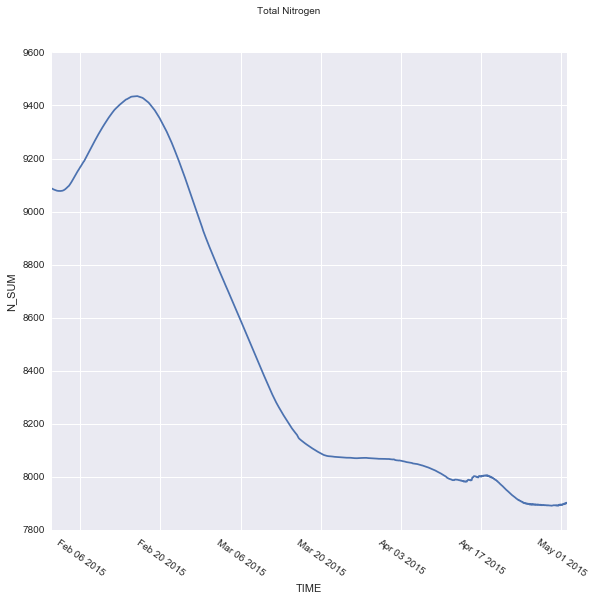

In [38]:
a = df_subset.groupby('time_counter').sum()[[ 'DOC','MICZ', 'MYRI', 'NH4', 'NO3', 'PHY', 'PHY2', 'POC']].sum(axis = 1)
a = pd.DataFrame(a)
a["TIME"] = a.index
a.columns = ["N_SUM", "TIME"]
fg = sns.FacetGrid(data=a,size =8)
fg.map(plt.plot, "TIME", "N_SUM").add_legend()
fg.set_xticklabels(rotation=-35)
plt.subplots_adjust(top=0.9)
fg.fig.suptitle("Total Nitrogen")


In [176]:
# Parent directory for the results of this run
group_results_directory = '/data/jpetrie/MEOPAR/SalishSea/results/param_search/'
tracer_file = 'SS5x5_1h_20150201_20150501_ptrc_T.nc'
individual_directories = []
param_vals = []
param_names = []
for file in os.listdir(group_results_directory):
    if os.path.isfile(group_results_directory + file + '/' + tracer_file):
        val = float(file.split("_")[-1])
        first_underscore = file.find("_")
        last_underscore = file.rfind("_")
        name = file[(first_underscore + 1):last_underscore]
        print(name)
        individual_directories.append(file)
        param_vals.append(val)
    else:
        print(group_results_directory + file + tracer_file)

dataframe_list = []   
for directory in individual_directories:
    df = (xr.open_dataset(group_results_directory + '/' + file +'/' + tracer_file))
    df.values[:,:,2,2]#.to_dataframe()

    dataframe_list.append(df)
a = pd.concat(dataframe_list)
    
    

#df_subset.reset_index(inplace=True) # Get rid of that multiindex madness


zz_rate_k_myri
zz_rate_iopt_nano
zz_rate_maxtemp_nano
zz_rate_temprange_diat
zz_rate_k_diat
zz_rate_r_myri
zz_rate_r_nano
zz_rate_kapa_nano
zzigamma
zzq_o
zz_rate_kapa_diat
zz_rate_kapa_myri
zz_rate_maxtemp_myri
zz_rate_maxtemp_diat
zz_rate_iopt_diat
zz_rate_temprange_myri
zz_rate_r_nano
zz_rate_temprange_diat
zz_rate_k_diat
zz_rate_k_myri
zz_rate_kapa_diat
zz_rate_r_nano
zzitheta
zz_rate_kapa_myri
zz_rate_iopt_nano
zz_rate_maxtemp_diat
zz_rate_r_myri
zz_rate_maxtemp_diat
zz_rate_r_diat
zz_rate_kapa_nano
zz_rate_temprange_myri
zz_w_sink_pmicro_max
zz_rate_k_si_diat
zzn2chl
zz_rate_maxtemp_myri
zzq_o
zzidl
zzisigma
zzalbedo
zzialpha
zz_w_sink_pmicro_min
zz_rate_maxtemp_myri
zz_rate_temprange_nano
zz_rate_maxtemp_myri
zz_rate_kapa_nano
zzq_o
zz_rate_iopt_myri
zz_rate_iopt_diat
zz_rate_r_myri
zz_rate_maxtemp_diat
zz_rate_iopt_myri
zz_rate_iopt_diat
zz_w_sink_pmicro_min
zz_rate_kapa_diat
zz_rate_r_diat
zz_rate_kapa_myri
zzn2chl
zz_rate_k_si_diat
zz_w_sink_pmicro_max
zz_rate_maxtemp_myri
zz

TypeError: 'method' object is not subscriptable